<a href="https://colab.research.google.com/github/OseiasBeu/Data-Science/blob/master/PreverPercentualDeAberturaDeEmails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas Utilizadas
Sessão para importar as bibliotecas que utilizarei. 

## Download de biblioteca para visualização de árvore binária 

In [ ]:
!pip install graphviz==0.10
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


##  Bibliotecas

In [4]:
from google.oauth2 import service_account
import pandas_gbq
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,accuracy_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import export_graphviz
import  graphviz
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

# Extração do Dataset

### Primeira query:
Essa query possui apenas as informações de entregabilidade.

In [1]:
query_string = '''

'''

### Segunda query:
Nessa segunda query fiz o cruzamento com a dimensão paciente do datamart para conseguir idade, genero e o id_mdm.

In [2]:
query_string_v2 = '''

'''

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/OseiasBeu/Data-Science/master/DataSets/dataset_open_email.csv', sep=';')
df.head(5)

,Envios,Entregas,DomainSent,Domain_class,Aberturas,patient_age,bu_tratado,genero_tratado,class_gender
0,1,1,hotmail.es,0,0,53,1,F,2.0
1,1,1,tec-rad.com.br,0,0,55,1,M,1.0
2,1,1,ymail.com,0,0,43,0,M,1.0
3,1,1,uniparcarbocloro.com.br,0,0,53,0,M,1.0
4,1,1,sidewalk.com.br,0,0,39,1,F,2.0


### Removendo duplicidades com base no ID.

In [ ]:
# print(f'Quantidade de registros na extração: {df.shape}')
# df = df.drop_duplicates(subset=['mdm_people_id'])
# print(f'Quantidade de regsitros após a remoção de duplicidades: {df.shape}')

# Analises descritivas

Informações básicas do dataset, como tipos de dados e contage mde valores não nulos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725360 entries, 0 to 725359
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Envios          725360 non-null  int64  
 1   Entregas        725360 non-null  int64  
 2   DomainSent      725360 non-null  object 
 3   Domain_class    725360 non-null  int64  
 4   Aberturas       725360 non-null  int64  
 5   patient_age     725360 non-null  int64  
 6   bu_tratado      725360 non-null  int64  
 7   genero_tratado  725360 non-null  object 
 8   class_gender    725360 non-null  float64
dtypes: float64(1), int64(6), object(2)
memory usage: 49.8+ MB


### Verificando features com valores nulos:
Desse modo podemos identificar com quais tipos de dados estamos trabalhando e além disso, verificar se existem dados nulos dentro do nosso dataset. Com essa visão já podemos dizer que temos sim. Agora, vamos fazer uma contagem e identificar exatamente quais são esses caras.

In [7]:
df.isnull().sum()

Envios            0
Entregas          0
DomainSent        0
Domain_class      0
Aberturas         0
patient_age       0
bu_tratado        0
genero_tratado    0
class_gender      0
dtype: int64

### Estatísticas básicas do dataset

In [8]:
df.describe()

,Envios,Entregas,Domain_class,Aberturas,patient_age,bu_tratado,class_gender
count,725360.0,725360.000000,725360.000000,725360.000000,725360.000000,725360.000000,725360.000000
mean,1.0,0.989828,2.160210,0.228646,48.453038,0.601883,1.820896
std,0.0,0.100340,1.746179,0.419961,13.491413,0.489510,0.396958
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,1.000000,0.000000,40.000000,0.000000,2.000000
50%,1.0,1.000000,1.000000,0.000000,47.000000,1.000000,2.000000
75%,1.0,1.000000,3.000000,0.000000,58.000000,1.000000,2.000000
max,1.0,1.000000,12.000000,1.000000,122.000000,1.000000,2.000000


### Média de idade do dataset

In [9]:
df.patient_age.mean()

48.45303849123194

### Agrupamentos de alguns campos:

In [10]:
df.groupby('Aberturas').count()

,Envios,Entregas,DomainSent,Domain_class,patient_age,bu_tratado,genero_tratado,class_gender
Aberturas,,,,,,,,
0,559509,559509,559509,559509,559509,559509,559509,559509
1,165851,165851,165851,165851,165851,165851,165851,165851


In [11]:
df.groupby('Envios').count()

,Entregas,DomainSent,Domain_class,Aberturas,patient_age,bu_tratado,genero_tratado,class_gender
Envios,,,,,,,,
1,725360,725360,725360,725360,725360,725360,725360,725360


In [12]:
df.groupby('bu_tratado').sum()

,Envios,Entregas,Domain_class,Aberturas,patient_age,class_gender
bu_tratado,,,,,,
0,288778,287372,616318,49986,12447453,455472.0
1,436582,430610,950612,115865,22698443,865333.0


#### Tratar esse campo:
* Gerar classes
* Corrigir acronimos

In [13]:
df.groupby(['genero_tratado']).sum()

,Envios,Entregas,Domain_class,Aberturas,patient_age,bu_tratado,class_gender
genero_tratado,,,,,,,
F,599271,592753,1300421,142993,29446773,431350,1198542.0
I,3826,3770,8369,816,180458,2599,0.0
M,122263,121459,258140,22042,5518665,2633,122263.0


### Classes de dominio:
Não vamos precisar tratar o campo `Domain_class` pois já o fizemos na extração do banco:

- 0 - Outros;
- 1 - Gmail;
- 2 - Outlook;
- 3 - Hotmail;
- 4 - Yahoo;
- 5 - Uol;
- 6 - Icloud;
- 7 - BOl;
- 8 - Ig;
- 9 - Terra;
- 10 - Live;
- 11 - Msn;
- 12 - Me;

In [14]:
df.groupby(['Domain_class']).sum()

,Envios,Entregas,Aberturas,patient_age,bu_tratado,class_gender
Domain_class,,,,,,
0,47389,45012,8057,2416965,28622,83227.0
1,348540,348162,115837,16789575,209429,635134.0
2,11532,11522,908,480028,4609,20164.0
3,205737,205087,13072,9714459,121800,377370.0
4,61345,60452,16235,3031307,41514,113985.0
5,25379,24828,6231,1451834,15157,45064.0
6,4262,4258,3012,184061,1882,7616.0
7,6536,6169,634,337498,4454,11960.0
8,6321,5278,363,334895,4381,11551.0


In [15]:
df.value_counts('Domain_class')

Domain_class
1     348540
3     205737
4      61345
0      47389
5      25379
2      11532
7       6536
8       6321
6       4262
9       3040
10      2574
11      1612
12      1093
dtype: int64

## Aplicar Tratamentos básicos

### Criar classes de BU:
* Unidade de negócios SP - 0
* Unidade de negócios RJ - 1

### Criar classes de Abertura:
* 1 - Sim
* 1 - Não

In [17]:
troca_abertura = {1:"Sim",
            0:"Não"}

df['abriu?'] = df.Aberturas.map(troca_abertura)
df.head()

,Envios,Entregas,DomainSent,Domain_class,Aberturas,patient_age,bu_tratado,genero_tratado,class_gender,abriu?
0,1,1,hotmail.es,0,0,53,1,F,2.0,Não
1,1,1,tec-rad.com.br,0,0,55,1,M,1.0,Não
2,1,1,ymail.com,0,0,43,0,M,1.0,Não
3,1,1,uniparcarbocloro.com.br,0,0,53,0,M,1.0,Não
4,1,1,sidewalk.com.br,0,0,39,1,F,2.0,Não


### Tratamento do genero:
Tudo o que for diferente de Masculino e Feminido entra como I.

Então temos:
* 2 - F - Feminino
* 1 - M - Masculino
* 0 - I - Indeterminado

In [18]:
df.groupby(['genero_tratado']).sum()

,Envios,Entregas,Domain_class,Aberturas,patient_age,bu_tratado,class_gender
genero_tratado,,,,,,,
F,599271,592753,1300421,142993,29446773,431350,1198542.0
I,3826,3770,8369,816,180458,2599,0.0
M,122263,121459,258140,22042,5518665,2633,122263.0


In [ ]:
# df.groupby(['origin_gender']).count()
# troca_genero = {  "FEMALE":"F",
#                   "FEMININO":"F",
#                   "M":"M",
#                   "F":"F",
#                   "MALE":"M",
#                   "MASCULINO":"M",
#                   "G":"I",
#                   "INDETERMINADO":"I",
#                   "NAO_INFORMADO":"I",
#                   "NONE":"I",
#                   "OTHER":"I",
#                   "N/D":"I",
#                   "N":"I",
#                   "INTERSEXUAL":"I",
#                   "":"I",
#                   "\\N":"I"
#                   }

# df['genero_tratado'] = df.origin_gender.map(troca_genero)
# df[['origin_gender','genero_tratado']].head(3)

In [19]:
troca_genero = {  "I":0,
                  "M":1,
                  "F":2,
                  }

df['class_gender'] = df.genero_tratado.map(troca_genero)
df = df.dropna()
df['class_gender'].astype('int64') #, errors='ignore'
df[['genero_tratado','class_gender']].value_counts()

genero_tratado  class_gender
F               2               599271
M               1               122263
I               0                 3826
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725360 entries, 0 to 725359
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Envios          725360 non-null  int64 
 1   Entregas        725360 non-null  int64 
 2   DomainSent      725360 non-null  object
 3   Domain_class    725360 non-null  int64 
 4   Aberturas       725360 non-null  int64 
 5   patient_age     725360 non-null  int64 
 6   bu_tratado      725360 non-null  int64 
 7   genero_tratado  725360 non-null  object
 8   class_gender    725360 non-null  int64 
 9   abriu?          725360 non-null  object
dtypes: int64(7), object(3)
memory usage: 60.9+ MB


In [21]:
df.groupby(['genero_tratado']).count()

,Envios,Entregas,DomainSent,Domain_class,Aberturas,patient_age,bu_tratado,class_gender,abriu?
genero_tratado,,,,,,,,,
F,599271,599271,599271,599271,599271,599271,599271,599271,599271
I,3826,3826,3826,3826,3826,3826,3826,3826,3826
M,122263,122263,122263,122263,122263,122263,122263,122263,122263


In [22]:
df.genero_tratado.shape

(725360,)

In [23]:
df.groupby(['class_gender']).count()

,Envios,Entregas,DomainSent,Domain_class,Aberturas,patient_age,bu_tratado,genero_tratado,abriu?
class_gender,,,,,,,,,
0,3826,3826,3826,3826,3826,3826,3826,3826,3826
1,122263,122263,122263,122263,122263,122263,122263,122263,122263
2,599271,599271,599271,599271,599271,599271,599271,599271,599271


# Montando Algumas Vizualizações para entender as distribuições

### Percentual de gêneros do dataset

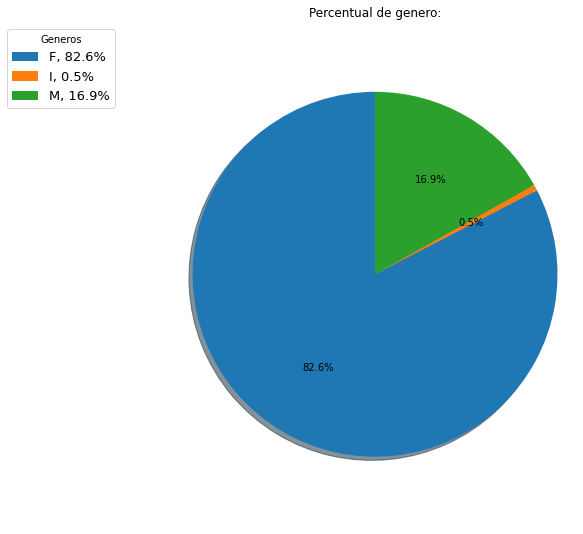

In [24]:
agrupamento_por_genero = df['genero_tratado'].groupby([df['genero_tratado']]).count() 
labels = ['F', 'I', 'M']
fig1, ax1 = plt.subplots(figsize=(8,7))
fig1.subplots_adjust(0.3,0,1,1)
ax1.pie(agrupamento_por_genero, autopct='%0.1f%%',frame=False,shadow=True, startangle=90) #radius=180000,autopct='%0.01f%%'

total = sum(agrupamento_por_genero)
ax1.legend(  
           title='Generos',
           loc = 'upper left',
           labels=['%s, %1.1f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, agrupamento_por_genero)],
           bbox_to_anchor=(0.0, 1),
           prop={'size': 13},
           bbox_transform=fig1.transFigure)
ax1.axis('equal')
plt.xticks(fontsize=1)
ax1.set_title('Percentual de genero:')
plt.show()

### Quantidade de aberturas e não aberturas por genero.

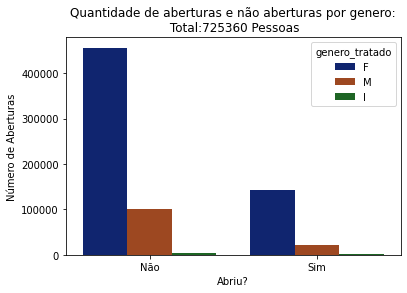

In [25]:
pessoas = sns.countplot(data = df, x ='abriu?', hue ='genero_tratado',palette='dark')
# for p in pessoas.patches:
#   b =p.get_bbox()
#  pessoas.annotate("{:.0f}".format(b.y1+b.y0),((b.x0 + b.x1)/2 -0.03,b.y1+15))
#
plt.title('Quantidade de aberturas e não aberturas por genero:\n Total:%s Pessoas' %(df.shape[0]))
plt.xlabel('Abriu?')
plt.ylabel('Número de Aberturas')
plt.show()

### Quantidade de envios por genero

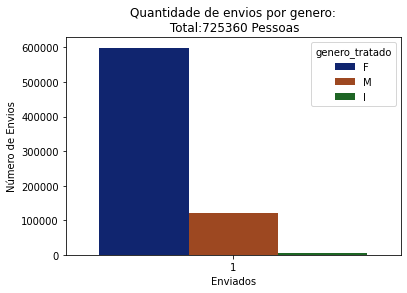

In [26]:
pessoas = sns.countplot(data = df, x ='Envios', hue ='genero_tratado',palette='dark')
for p in pessoas.patches:
  b =p.get_bbox()
  # pessoas.annotate("{:.0f}".format(b.y1+b.y0),((b.x0 + b.x1)/2 -0.03,b.y1+15))

# plt.figure(figsize=(17,15))
plt.title('Quantidade de envios por genero:\n Total:%s Pessoas' %(df.shape[0]))
plt.xlabel('Enviados')
plt.ylabel('Número de Envios')
plt.show()

### Proporção de abertura por genero (masculino, feminino e indefinido) com mais facilidade.

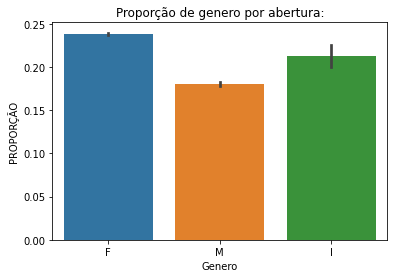

In [27]:
abertura_classe = df.copy()
abertura_classe['abriu?'] = df['abriu?'] == 'Sim'

sns.barplot(data=abertura_classe, y='abriu?', x='genero_tratado')
plt.title('Proporção de genero por abertura:')
plt.ylabel('PROPORÇÃO')
plt.xlabel('Genero')
plt.show()

In [28]:
df[df['abriu?'] == 'Sim']['genero_tratado'].value_counts().sort_values(ascending=True)

I       816
M     22042
F    142993
Name: genero_tratado, dtype: int64

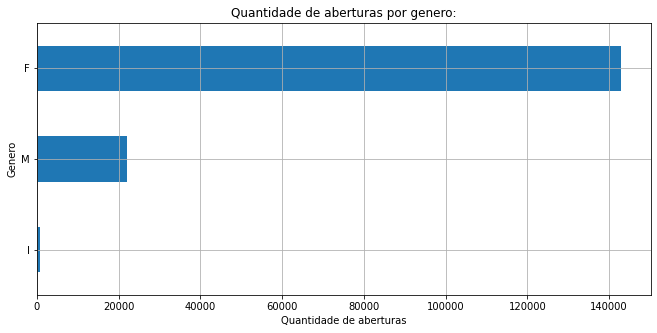

In [29]:
genero_por_abertura = df[df['abriu?'] == 'Sim']['genero_tratado'].value_counts().sort_values(ascending=True)

genero_por_abertura
genero_por_abertura.plot(kind='barh',figsize=(11,5),rot=0,grid=True)

plt.title('Quantidade de aberturas por genero:')
plt.xlabel('Quantidade de aberturas')
plt.ylabel('Genero')
plt.show()  

### Gerar matriz de correlação

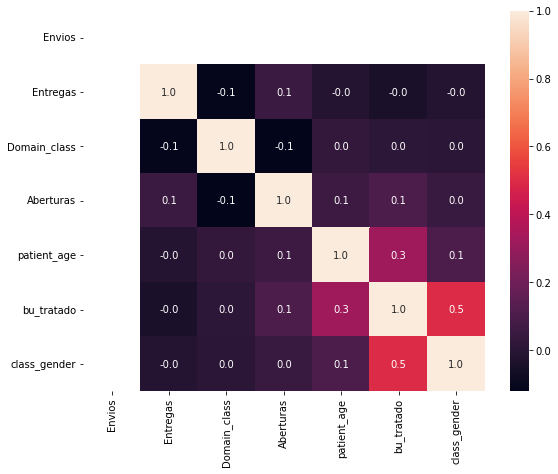

In [30]:
corrMatrix = df.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corrMatrix, annot=True,fmt='.1f')
plt.show()

# Modelos 

## Preparando a Base para os modelos.

In [ ]:
df[:1].values

array([['CRISTIANEMARTIN12101968', 1, 1, 'hotmail.es', 0,
        'DASA - DELBONI AURIEMO', 0, 17769193, 53, 'F',
        'CRISTIANEMARTIN12101968', 1, 'Não', 'F', 2.0]], dtype=object)

In [ ]:
df.columns

Index(['SubscriberKey', 'Envios', 'Entregas', 'DomainSent', 'Domain_class',
       'BU', 'Aberturas', 'mdm_people_id', 'patient_age', 'origin_gender',
       'pacid', 'bu_tratado', 'abriu?', 'genero_tratado', 'class_gender'],
      dtype='object')

Separação de:
* x = Features (variaveis)
* y = Valor previsto

In [31]:
X = df[['Entregas', 'Domain_class', 'bu_tratado','class_gender','patient_age']]
y = df[['Aberturas']]

## Escolhendo as melhores Features:

In [ ]:
selecionar_kmelhores = SelectKBest(chi2,k=5)

Separação de bases para treino e teste:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
X_train.shape

(507752, 5)

In [ ]:
selecionar_kmelhores.fit(X_train,y_train)
treino_kbest= selecionar_kmelhores.transform(X_train)
teste_kbest= selecionar_kmelhores.transform(X_test)

In [ ]:
treino_kbest.shape

(507752, 5)

In [ ]:
teste_kbest.shape

(217608, 5)

No caso utilizaremos todas as variáveis que possuímos. Caso façamos a inclusão de mais variáveis, vamos precisar executar essa seleção novamente.

In [ ]:
X_train.head()
# X_train.info()

,Entregas,Domain_class,bu_tratado,class_gender,patient_age
60217,1,0,1,2.0,54
1068618,1,3,0,1.0,24
892366,1,1,0,2.0,35
1241005,1,3,1,2.0,44
65558,1,0,1,2.0,46


In [ ]:
y_train.head()

,Aberturas
60217,0
1068618,0
892366,0
1241005,0
65558,0


## Aplicando Modelo de Vetor de Suporte:

In [ ]:
svc_model = LinearSVC()
svc_model.fit(X_train,y_train)

LinearSVC()

In [ ]:
predito_svc = svc_model.predict(X_test)
predito_svc

array([0, 0, 0, ..., 0, 0, 0])

## Método baseado na proximidade
Modelo K-nearest neighbors (KNN)

In [ ]:
norm = StandardScaler()
X_normalizado = norm.fit_transform(X)
X_normalizado

array([[ 0.10137072, -1.23710775,  0.81329694,  0.45119251,  0.33702656],
       [ 0.10137072, -1.23710775,  0.81329694, -2.06797003,  0.4852691 ],
       [ 0.10137072, -1.23710775, -1.22956321, -2.06797003, -0.40418614],
       ...,
       [ 0.10137072,  1.05360971,  0.81329694,  0.45119251,  0.55939037],
       [ 0.10137072,  1.05360971,  0.81329694,  0.45119251,  0.18878402],
       [ 0.10137072,  1.05360971,  0.81329694,  0.45119251, -0.2559436 ]])

In [ ]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_normalizado, y, test_size=0.3, random_state=42)

In [ ]:
knn_model = KNeighborsClassifier(metric='euclidean')

In [ ]:
knn_model.fit(X_treino, y_treino)

KNeighborsClassifier(metric='euclidean')

In [ ]:
predito_knn = knn_model.predict(X_teste)
predito_knn

array([0, 0, 0, ..., 1, 0, 0])

## Método Probabilístico

### Aplicando Modelo de Regressão Logistica:

In [ ]:
logReg_model = LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
logReg_model.fit(X_train, y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
predito_regLog = logReg_model.predict(X_test)

In [ ]:
#Utilizando o K melhores
logReg_model.fit(treino_kbest, y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [ ]:
predito_regLog_kbest = logReg_model.predict(teste_kbest)

In [ ]:
acerto_regLog = accuracy_score(y_test, predito_regLog)
acerto_regLog

0.7724026690195214

In [ ]:
acerto_regLog_kbest = accuracy_score(y_test, predito_regLog_kbest)
acerto_regLog_kbest

0.7724026690195214

In [ ]:
# Predizendo as probabilidades
predito_proba_regLog = logReg_model.predict_proba(X_test)
print(predito_proba_regLog)

[[0.78020752 0.21979248]
 [0.80942419 0.19057581]
 [0.80972954 0.19027046]
 ...
 [0.91744543 0.08255457]
 [0.7621156  0.2378844 ]
 [0.87436871 0.12563129]]


In [ ]:
# predito_regLog = predito_regLog[:, 1] # manter somente para a classe positiva

In [ ]:
# confusion_matrix(y, model.predict(X)) # usando a função do sklearn

In [ ]:
print(classification_report(y_test,predito_regLog))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



In [ ]:
# teste = pd.DataFrame({'Envios':10, 'Entregas':6, 'Domain_class':3, 'bu_tratado':1}, index=[0])

In [ ]:
# teste = pd.DataFrame({'Envios':10, 'Entregas':6, 'Domain_class':3, 'bu_tratado':1}, index=[0])
# minha_prob = logReg_model.predict_proba(teste)
# print(round(minha_prob[:,1][0]*100, 2))

###  Modelo Bernoulli Naive Bayes


In [ ]:
bnb_model = BernoulliNB(binarize=-0.44)

In [ ]:
#escolho utilizar mediana, porque é o valor central dos nossos dados ordenados
np.median(X_train)

1.0

In [ ]:
#treinar o modelo
bnb_model.fit(X_train, y_train)

BernoulliNB(binarize=-0.44)

In [ ]:
#testar o modelo
predito_BNb = bnb_model.predict(X_test)
predito_BNb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
print(classification_report(y_test, predito_BNb))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



## Método Simbólico

### Árvore de decisão

In [ ]:
#instanciando o modelo
dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
#treinar o modelo
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
predito_ArvoreDecisao = dtc_model.predict(X_test)
predito_ArvoreDecisao

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
# export_graphviz(modelo)
# dot_data = export_graphviz(modelo, out_file=None)
# grafico = graphviz.Source(dot_data)
# grafico

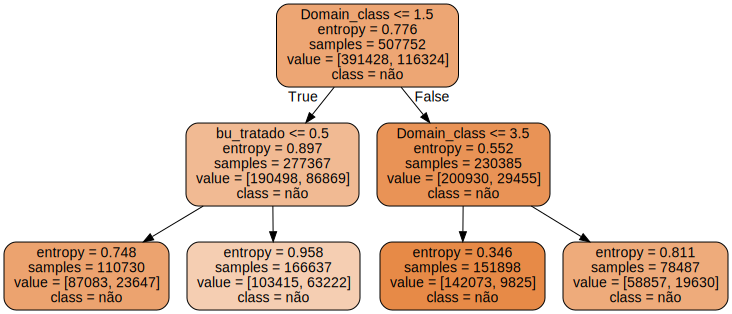

In [ ]:
#instanciando o modelo
dtc_model_v2 = DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=2)
#treinar o modelo
dtc_model_v2.fit(X_train, y_train)
features = X.columns
dot_data = export_graphviz(dtc_model_v2, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["não", "sim"])
grafico = graphviz.Source(dot_data)
grafico

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from numpy import random

SEED = 42
random.seed(SEED)
rdf_model = RandomForestClassifier(n_estimators = 100)
rdf_model.fit(X_train, y_train)
predito_rdf =  rdf_model.predict(X_test)
print("Resultado da classificação %.2f%%" %(rdf_model.score(X_test, y_test)*100))

Resultado da classificação 77.53%


In [ ]:
# confusion_matrix(y_test, predito_rdf)

In [ ]:
# acerto_Rdf = accuracy_score(y_test, predito_rdf)
# acerto_Rdf

In [ ]:
# precision_score(y_test, predito_rdf)
# recall_score(y_test, predito_rdf)

In [ ]:
from sklearn.dummy import DummyClassifier
import random
SEED = 42
random.seed(SEED)

classificador_bobo = DummyClassifier(strategy= "most_frequent")
classificador_bobo.fit(X_train, y_train)

print("Resultado da classificação boba %.2f%%" %(classificador_bobo.score(X_test, y_test)*100))

Resultado da classificação boba 77.24%


In [ ]:
predito_bobo = classificador_bobo.predict(X_test)

# Validação dos modelos:

## Matriz de confusão: 
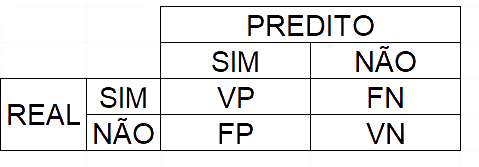

In [ ]:
print(f'''
> Matriz SVC: \n {confusion_matrix(y_test, predito_svc)}

> Matriz KNN: \n {confusion_matrix(y_test, predito_knn)}

> Matriz BNB: \n {confusion_matrix(y_test,predito_BNb)}

> Matriz Reg.Log: \n {confusion_matrix(y_test, predito_regLog)}

> Matriz DTC: \n {confusion_matrix(y_test, predito_ArvoreDecisao)}

> Matriz RDF: \n {confusion_matrix(y_test, predito_rdf)}

> Matriz Bobo: \n {confusion_matrix(y_test, predito_bobo)}
''')


> Matriz SVC: 
 [[168081      0]
 [ 49527      0]]

> Matriz KNN: 
 [[150208  17873]
 [ 39011  10516]]

> Matriz BNB: 
 [[168081      0]
 [ 49527      0]]

> Matriz Reg.Log: 
 [[168081      0]
 [ 49527      0]]

> Matriz DTC: 
 [[167567    514]
 [ 48396   1131]]

> Matriz RDF: 
 [[167533    548]
 [ 48352   1175]]

> Matriz Bobo: 
 [[168081      0]
 [ 49527      0]]



[Text(38.5, 0.5, 'Real'), Text(0.5, 20.5, 'Predição')]

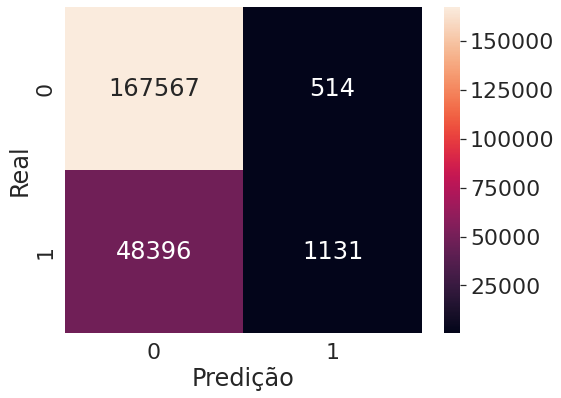

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(y_test, predito_ArvoreDecisao), annot=True,fmt='d').set(xlabel='Predição',ylabel='Real')

[Text(38.5, 0.5, 'Real'), Text(0.5, 20.5, 'Predição')]

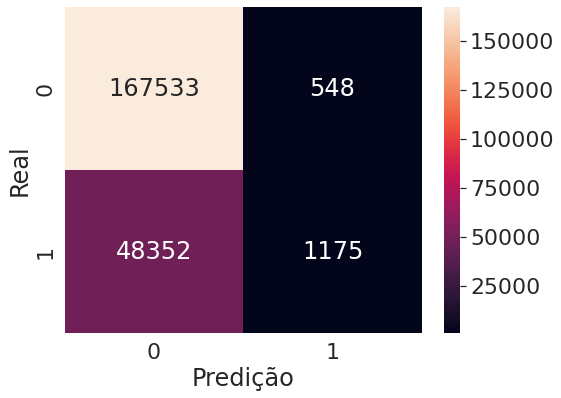

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)
sns.heatmap(confusion_matrix(y_test, predito_rdf), annot=True,fmt='d').set(xlabel='Predição',ylabel='Real')

## Acurácia
acurária - Quanto o modelo está acertando

In [ ]:
acerto_svc = accuracy_score(y_test, predito_svc)
acerto_knn = accuracy_score(y_test, predito_knn)
acerto_bnb = accuracy_score(y_test, predito_BNb)
acerto_regLog = accuracy_score(y_test, predito_regLog)
acerto_ArvoreDecisao = accuracy_score(y_test, predito_ArvoreDecisao)
acerto_Rdf = accuracy_score(y_test, predito_rdf)
acerto_bobo = accuracy_score(y_test, predito_bobo)
print(f'''
Acurácia do SVC: {acerto_svc}
Acurácia do KNN: {acerto_knn}
Acurácia do BNb: {acerto_bnb}
Acurácia da Reg.log: {acerto_regLog}
Acurácia da DTC: {acerto_ArvoreDecisao}
Acurácia do RDF: {acerto_Rdf}
Acurácia do Bobo: {acerto_bobo}
''')


Acurácia do SVC: 0.7724026690195214
Acurácia do KNN: 0.7385941693320098
Acurácia do BNb: 0.7724026690195214
Acurácia da Reg.log: 0.7724026690195214
Acurácia da DTC: 0.7752380427190176
Acurácia do RDF: 0.7752839969118782
Acurácia do Bobo: 0.7724026690195214



## Precisão:
precisão - Quantos foram classificados corretamento como positivos ($TP$).

In [ ]:
print(f'''
    > Precisão SVC: {precision_score(y_test, predito_svc)}
    > Precisão KNN: {precision_score(y_teste, predito_knn)}
    > Precisão BNB: {precision_score(y_test, predito_BNb)}
    > Precisão da RegLog: {precision_score(y_test, predito_regLog)}
    > Precisão da ArvoreDecisao = {precision_score(y_test, predito_ArvoreDecisao)}
    > Precisão da RDF = {precision_score(y_test, predito_rdf)}
    > Precisão do bobo = {precision_score(y_test, predito_bobo)}
    ''')


    > Precisão SVC: 0.0
    > Precisão KNN: 0.3704251646764592
    > Precisão BNB: 0.0
    > Precisão da RegLog: 0.0
    > Precisão da ArvoreDecisao = 0.6875379939209726
    > Precisão da RDF = 0.681950087057458
    > Precisão do bobo = 0.0
    


## Recall:
sensibilidade: Quão bom o modelo está para classificar corretamente um resultado positivo ($TP$).

In [ ]:
print(f'''
    > Sensibilidade SVC: {recall_score(y_test, predito_svc)}
    > Sensibilidade KNN: {recall_score(y_teste, predito_knn)}
    > Sensibilidade BNB: {recall_score(y_test, predito_BNb)}
    > Sensibilidade da RegLog: {recall_score(y_test, predito_regLog)}
    > Sensibilidade da ArvoreDecisao = {recall_score(y_test, predito_ArvoreDecisao)}
    > Sensibilidade da RDF = {recall_score(y_test, predito_rdf)}
    > Sensibilidade do bobo = {recall_score(y_test, predito_bobo)}
    ''')


    > Sensibilidade SVC: 0.0
    > Sensibilidade KNN: 0.2123286288287197
    > Sensibilidade BNB: 0.0
    > Sensibilidade da RegLog: 0.0
    > Sensibilidade da ArvoreDecisao = 0.022836028832757888
    > Sensibilidade da RDF = 0.023724433137480565
    > Sensibilidade do bobo = 0.0
    


## Outros Métodos

In [ ]:
print(classification_report(y_test, predito_bobo))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



In [ ]:
print(classification_report(y_test, predito_BNb))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



In [ ]:
print(classification_report(y_test, predito_svc))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



In [ ]:
print(classification_report(y_teste, predito_knn))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84    168081
           1       0.37      0.21      0.27     49527

    accuracy                           0.74    217608
   macro avg       0.58      0.55      0.56    217608
weighted avg       0.70      0.74      0.71    217608



In [ ]:
print(classification_report(y_teste, predito_regLog))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87    168081
           1       0.00      0.00      0.00     49527

    accuracy                           0.77    217608
   macro avg       0.39      0.50      0.44    217608
weighted avg       0.60      0.77      0.67    217608



In [ ]:
print(classification_report(y_teste, predito_ArvoreDecisao))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    168081
           1       0.69      0.02      0.04     49527

    accuracy                           0.78    217608
   macro avg       0.73      0.51      0.46    217608
weighted avg       0.76      0.78      0.68    217608



In [ ]:
print(classification_report(y_test, predito_rdf))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    168081
           1       0.68      0.02      0.05     49527

    accuracy                           0.78    217608
   macro avg       0.73      0.51      0.46    217608
weighted avg       0.75      0.78      0.68    217608



# Testes Específicos de probabilidade

In [ ]:
X_train.head()

,Entregas,Domain_class,bu_tratado,class_gender,patient_age
688260,1,1,1,2.0,71
81496,1,0,0,2.0,34
284572,1,1,1,2.0,45
324846,1,1,0,1.0,55
1524080,1,4,1,2.0,40


In [ ]:
persona_x = pd.DataFrame({
    'Entregas':1, 
    'Domain_class':1, #Gmail
    'bu_tratado':1, # Delb
    'class_gender':0,# H
    'patient_age':73 
    }, index=[0])

In [ ]:
prob_persona_x_logReg = logReg_model.predict_proba(persona_x)
prob_persona_x_BNb = bnb_model.predict_proba(persona_x)
prob_persona_x_knn = knn_model.predict_proba(persona_x)
prob_persona_x_rdf = rdf_model.predict_proba(persona_x)
prob_persona_x_dtc = dtc_model.predict_proba(persona_x)


print(
    f'''
    ->Percentual de abertura com regressão logística: {round(prob_persona_x_logReg[:,1][0]*100, 2)}

    ->Percentual de abertura com Naive Bayes: {round(prob_persona_x_BNb[:,1][0]*100, 2)}

    ->Percentual de abertura com KNN: {round(prob_persona_x_knn[:,1][0]*100, 2)}

    ->Percentual de abertura com DTC: {round(prob_persona_x_dtc[:,1][0]*100, 2)}

    ->Percentual de abertura com RDF: {round(prob_persona_x_rdf[:,1][0]*100, 2)}
    ''')


    ->Percentual de abertura com regressão logística: 34.52

    ->Percentual de abertura com Naive Bayes: 22.91

    ->Percentual de abertura com KNN: 20.0

    ->Percentual de abertura com DTC: 20.0

    ->Percentual de abertura com RDF: 17.08
    


In [ ]:
prob_persona_x_rdf

array([[0.59059073, 0.40940927]])

In [ ]:
# prob_persona_x_rdf = classificador.predict_proba(persona_x)
# round(prob_persona_x_rdf[:,1][0]*100, 2)

In [ ]:
df_simulation = df.copy()
df_simulation['chance_abertura_logReg'] = 0
df_simulation['chance_abertura_BnB'] = 0
df_simulation['chance_abertura_knn'] = 0
df_simulation['chance_abertura_random_forest'] = 0
df_simulation['chance_abertura_decision_tree'] = 0

In [ ]:
df_simulation.shape[0]

725360

In [ ]:
for index in df_simulation.index:
  persona_sim = pd.DataFrame({
    'Entregas': df_simulation['Entregas'][index], 
    'Domain_class': df_simulation['Domain_class'][index], 
    'bu_tratado': df_simulation['bu_tratado'][index],
    'class_gender': df_simulation['class_gender'][index],
    'patient_age': df_simulation['patient_age'][index]
    }, index=[0])
  persona_x_logReg = logReg_model.predict_proba(persona_sim)
  prob_persona_x_BNb = bnb_model.predict_proba(persona_sim)
  prob_persona_x_knn = knn_model.predict_proba(persona_sim)
  prob_persona_x_rdf = rdf_model.predict_proba(persona_sim)
  prob_persona_x_dtc = dtc_model.predict_proba(persona_sim)

  df_simulation['chance_abertura_logReg'][index] = round(persona_x_logReg[:,1][0]*100, 2)
  df_simulation['chance_abertura_BnB'][index] = round(prob_persona_x_BNb[:,1][0]*100, 2)
  df_simulation['chance_abertura_knn'][index] = round(prob_persona_x_knn[:,1][0]*100, 2)
  df_simulation['chance_abertura_random_forest'][index] = round(prob_persona_x_rdf[:,1][0]*100, 2)
  df_simulation['chance_abertura_decision_tree'][index] = round(prob_persona_x_dtc[:,1][0]*100, 2)
  print(f'--> Já foram:{index} de: {df_simulation.shape[0]}')

df_simulation.to_csv('dataset_with_open_percent_18072022.csv',sep=';',encoding='utf-8')

A saída de streaming foi truncada nas últimas 5000 linhas.
--> Já foram:1583916 de: 725360
--> Já foram:1583928 de: 725360
--> Já foram:1583930 de: 725360
--> Já foram:1583931 de: 725360
--> Já foram:1583932 de: 725360
--> Já foram:1583933 de: 725360
--> Já foram:1583939 de: 725360
--> Já foram:1583943 de: 725360
--> Já foram:1583944 de: 725360
--> Já foram:1583945 de: 725360
--> Já foram:1583946 de: 725360
--> Já foram:1583948 de: 725360
--> Já foram:1583957 de: 725360
--> Já foram:1583958 de: 725360
--> Já foram:1583968 de: 725360
--> Já foram:1583980 de: 725360
--> Já foram:1583985 de: 725360
--> Já foram:1583991 de: 725360
--> Já foram:1583992 de: 725360
--> Já foram:1583998 de: 725360
--> Já foram:1583999 de: 725360
--> Já foram:1584000 de: 725360
--> Já foram:1584018 de: 725360
--> Já foram:1584027 de: 725360
--> Já foram:1584031 de: 725360
--> Já foram:1584032 de: 725360
--> Já foram:1584033 de: 725360
--> Já foram:1584041 de: 725360
--> Já foram:1584053 de: 725360
--> Já foram:

In [ ]:
df_simulation.shape

(725360, 20)

In [ ]:
# df_simulation.to_csv('dataset_with_open_percent.csv',sep=';',encoding='utf-8')

In [ ]:
df_simulation.head()

,SubscriberKey,Envios,Entregas,DomainSent,Domain_class,BU,Aberturas,mdm_people_id,patient_age,origin_gender,pacid,bu_tratado,abriu?,genero_tratado,class_gender,chance_abertura_logReg,chance_abertura_BnB
0,FERNANDOHENRIQU26121992,1,1,telefonica.com,0,DASA - SP,0,6070482,29,M,FERNANDOHENRIQU26121992,0,Não,M,1.0,22,22
1,RODRIGOLIMAMART01091986,1,1,dellacont.com.br,0,DASA - SP,1,17821409,35,M,RODRIGOLIMAMART01091986,0,Sim,M,1.0,22,22
3,MILENARODRIGUES17011976,1,1,terra.com.br,9,DASA - SP,1,6772987,46,F,MILENARODRIGUES17011976,0,Sim,F,2.0,5,22
5,PERCIVALARMANDO22011956,1,1,metaambiental.eng.br,0,DASA - SP,1,7565607,66,M,PERCIVALARMANDO22011956,0,Sim,M,1.0,26,22
7,THIAGODESOUZAME28101980,1,1,me.com,12,DASA - SP,0,6706854,41,M,THIAGODESOUZAME28101980,0,Não,M,1.0,2,22


In [ ]:
df_simulation.columns

Index(['SubscriberKey', 'Envios', 'Entregas', 'DomainSent', 'Domain_class',
       'BU', 'Aberturas', 'mdm_people_id', 'patient_age', 'origin_gender',
       'pacid', 'bu_tratado', 'abriu?', 'genero_tratado', 'class_gender',
       'chance_abertura_logReg', 'chance_abertura_BnB', 'chance_abertura_knn',
       'chance_abertura_random_forest', 'chance_abertura_decision_tree'],
      dtype='object')

In [ ]:
df_simulation[['SubscriberKey','abriu?','chance_abertura_logReg', 'chance_abertura_BnB']].head(20)

,SubscriberKey,abriu?,chance_abertura_logReg,chance_abertura_BnB
0,FERNANDOHENRIQU26121992,Não,22,22
1,RODRIGOLIMAMART01091986,Sim,22,22
3,MILENARODRIGUES17011976,Sim,5,22
5,PERCIVALARMANDO22011956,Sim,26,22
7,THIAGODESOUZAME28101980,Não,2,22
8,CARMENFERNANDAV25041976,Sim,19,22
9,REGINACELIADASI05051960,Não,36,22
10,VERADAPENHAMART01121953,Sim,37,22
11,JOSELMASILVAGON28121975,Sim,34,22
12,RAQUELGUADAGNOL27071974,Não,19,22


In [ ]:
# persona_x_logRed = logReg_model.predict(persona_x)
# persona_x_BNb = bnb_model.predict(persona_x)

# print(persona_x_logRed,persona_x_BNb)

[0] [0]


In [ ]:
# prob_persona_x_BNb
# 0.77


array([[0.77181574, 0.22818426]])

[0] [0]
